# MARKETING CAMPAIGNS AND SALES PREDICTIONS

In [308]:
!pip install pydot

In [309]:
import random
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import pydot
import seaborn as sns
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

In [127]:
random_seed = 54
np.random.seed(random_seed)
random.seed(random_seed)

In [128]:
FILE_SOURCE = 'marketing_campaigns.csv'

## 1. DATA PREPROCESSING

### Loading data

In [129]:
def load_data(file):
    return pd.read_csv(file)

In [130]:
df_marketing_sales = load_data(FILE_SOURCE)

In [131]:
df_marketing_sales.head()

,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


In [132]:
df_marketing_sales.describe()

,TV,Radio,Social Media,Sales
count,4562.000000,4568.000000,4566.000000,4566.000000
mean,54.066857,18.160356,3.323956,192.466602
std,26.125054,9.676958,2.212670,93.133092
min,10.000000,0.000684,0.000031,31.199409
25%,32.000000,10.525957,1.527849,112.322882
50%,53.000000,17.859513,3.055565,189.231172
75%,77.000000,25.649730,4.807558,272.507922
max,100.000000,48.871161,13.981662,364.079751


In [133]:
df_marketing_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TV            4562 non-null   float64
 1   Radio         4568 non-null   float64
 2   Social Media  4566 non-null   float64
 3   Influencer    4572 non-null   object 
 4   Sales         4566 non-null   float64
dtypes: float64(4), object(1)
memory usage: 178.7+ KB


### Null values treatment

In [134]:
# Numero de valores nulos
df_marketing_sales.isna().sum(axis=0)

TV              10
Radio            4
Social Media     6
Influencer       0
Sales            6
dtype: int64

In [135]:
# Porcentaje de valores nulos por campo
df_marketing_sales.isna().sum(axis=0)*100/df_marketing_sales.shape[0]

TV              0.218723
Radio           0.087489
Social Media    0.131234
Influencer      0.000000
Sales           0.131234
dtype: float64

In [136]:
# Primera aproximacion: eliminar los valores nulos

# Eliminando los valores nulos que porcentaje de datos nos quedaria
df_marketing_sales.dropna().shape[0] * 100 / df_marketing_sales.shape[0]

# No quedariamos con el 99% de los datos no estaria mal, podemos elinarlos

99.4313210848644

In [137]:
# Segunda aproximacion: sustitucion de valores

df_marketing_sales['TV'] = df_marketing_sales['TV'].fillna(df_marketing_sales['TV'].mean())
df_marketing_sales['Radio'] = df_marketing_sales['Radio'].fillna(df_marketing_sales['Radio'].mean())
df_marketing_sales['Social Media'] = df_marketing_sales['Social Media'].fillna(df_marketing_sales['Social Media'].mean())
df_marketing_sales['Influencer'] = df_marketing_sales['Influencer'].fillna(df_marketing_sales['Influencer'].mode())
df_marketing_sales['Sales'] = df_marketing_sales['Sales'].fillna(df_marketing_sales['Sales'].mean())

In [138]:
df_marketing_sales.describe()

,TV,Radio,Social Media,Sales
count,4572.000000,4572.000000,4572.000000,4572.000000
mean,54.066857,18.160356,3.323956,192.466602
std,26.096461,9.672723,2.211218,93.071947
min,10.000000,0.000684,0.000031,31.199409
25%,32.000000,10.546519,1.529879,112.397660
50%,53.000000,17.875181,3.057150,189.632530
75%,77.000000,25.647476,4.805832,272.414914
max,100.000000,48.871161,13.981662,364.079751


In [139]:
df_marketing_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TV            4572 non-null   float64
 1   Radio         4572 non-null   float64
 2   Social Media  4572 non-null   float64
 3   Influencer    4572 non-null   object 
 4   Sales         4572 non-null   float64
dtypes: float64(4), object(1)
memory usage: 178.7+ KB


### Encoding data

In [140]:
# Datos categoricos
df_marketing_sales['Influencer'].unique()

array(['Mega', 'Micro', 'Nano', 'Macro'], dtype=object)

In [141]:
# Hay una relacion de orden
df_marketing_sales['Influencer'] = df_marketing_sales['Influencer'].map({
    'Macro': 4,
    'Mega': 3,
    'Micro': 2,
    'Nano': 1
})

### Detecting outliers

Detección de outliers para atributos continuos

In [142]:
atributos_continuos = ['TV', 'Radio', 'Social Media', 'Sales']
atributos_categoricos = ['Influencer']

In [143]:
df_marketing_sales.describe()

,TV,Radio,Social Media,Influencer,Sales
count,4572.000000,4572.000000,4572.000000,4572.000000,4572.000000
mean,54.066857,18.160356,3.323956,2.494969,192.466602
std,26.096461,9.672723,2.211218,1.113243,93.071947
min,10.000000,0.000684,0.000031,1.000000,31.199409
25%,32.000000,10.546519,1.529879,2.000000,112.397660
50%,53.000000,17.875181,3.057150,2.000000,189.632530
75%,77.000000,25.647476,4.805832,3.000000,272.414914
max,100.000000,48.871161,13.981662,4.000000,364.079751


In [144]:
def remove_outliers_IQR(df,df_column,otype):
    # Calculamos el rango intercuartilico
    Q1 = df_column.quantile(0.25)
    Q3 = df_column.quantile(0.75)
    IQR = Q3 - Q1
    # Detectamos indices de los outliers
    df2 = None
    if otype=="up":
        df2 = df[~(df_column > (Q3 + 1.5 * IQR))]
    elif otype=="down":
        df2 = df[~(df_column < (Q1 - 1.5 * IQR))]
    elif otype=="both":
        df2 = df[~(df_column < (Q1 - 1.5 * IQR)) | (df_column > (Q3 + 1.5 * IQR))]
    else:
        df2 = df
    return df2

<Axes: >

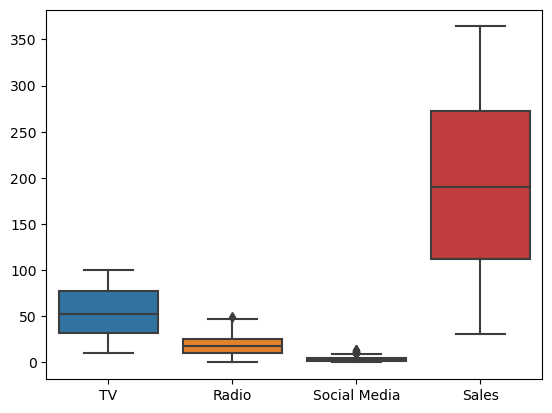

In [145]:
# Deteccion de outliers mediante boxplot como herramienta de estadistica
# descriptiva

sns.boxplot(data=df_marketing_sales[atributos_continuos])

<Axes: >

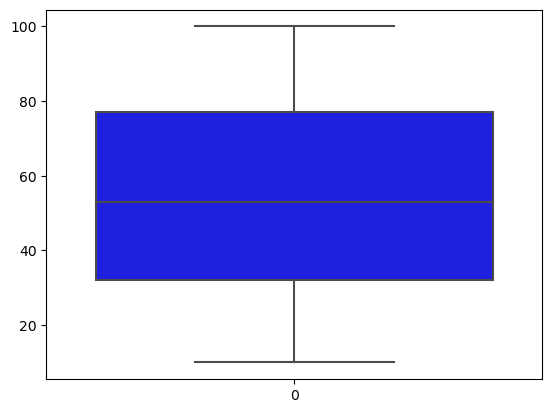

In [146]:
# Deteccion de outliers en el atributo TV

sns.boxplot(data=df_marketing_sales['TV'], color="b")
# No detectamos outliers

<Axes: >

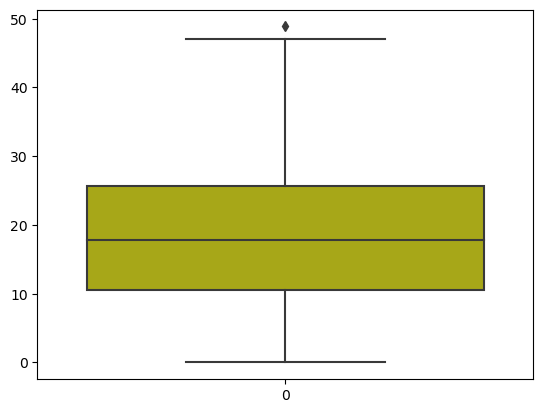

In [147]:
# Deteccion de outliers en el atributo Radio

sns.boxplot(data=df_marketing_sales['Radio'], color='y')
# Detectamos outliers superiores

In [148]:
# Eliminacion de outliers de Radio

print(df_marketing_sales.shape, remove_outliers_IQR(df_marketing_sales,df_marketing_sales['Radio'],"up").shape)

df_marketing_sales = remove_outliers_IQR(df_marketing_sales,df_marketing_sales['Radio'],"up")
df_marketing_sales

(4572, 5) (4571, 5)


,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,3,54.732757
1,13.0,9.237765,2.409567,3,46.677897
2,41.0,15.886446,2.913410,3,150.177829
3,83.0,30.020028,6.922304,3,298.246340
4,15.0,8.437408,1.405998,2,56.594181
...,...,...,...,...,...
4567,26.0,4.472360,0.717090,2,94.685866
4568,71.0,20.610685,6.545573,1,249.101915
4569,44.0,19.800072,5.096192,2,163.631457
4570,71.0,17.534640,1.940873,4,253.610411


<Axes: >

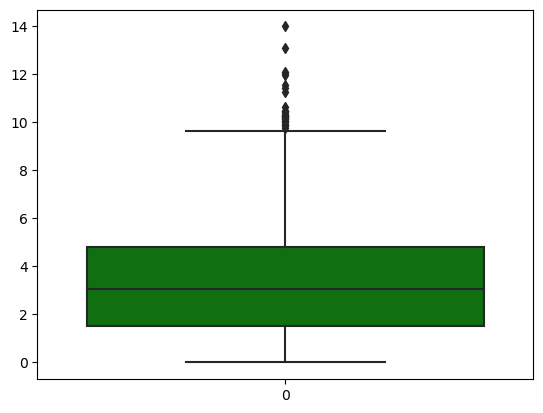

In [149]:
# Deteccion de outliers en el atributo Social Media

sns.boxplot(data=df_marketing_sales['Social Media'], color='g')

In [150]:
# Eliminacion de outliers de Social Media

print(df_marketing_sales.shape, remove_outliers_IQR(df_marketing_sales,df_marketing_sales['Social Media'],"up").shape)

df_marketing_sales = remove_outliers_IQR(df_marketing_sales,df_marketing_sales['Social Media'],"up")
df_marketing_sales

(4571, 5) (4543, 5)


,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,3,54.732757
1,13.0,9.237765,2.409567,3,46.677897
2,41.0,15.886446,2.913410,3,150.177829
3,83.0,30.020028,6.922304,3,298.246340
4,15.0,8.437408,1.405998,2,56.594181
...,...,...,...,...,...
4567,26.0,4.472360,0.717090,2,94.685866
4568,71.0,20.610685,6.545573,1,249.101915
4569,44.0,19.800072,5.096192,2,163.631457
4570,71.0,17.534640,1.940873,4,253.610411


<Axes: >

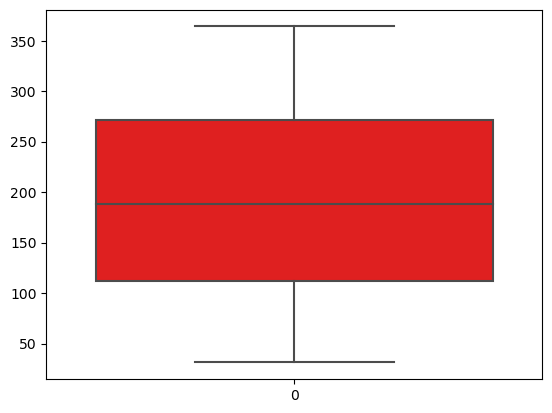

In [151]:
# Deteccion de outliers en el atributo Sales

sns.boxplot(data=df_marketing_sales['Sales'], color='r')

## 2. EXPLORATORY DATA ANALYSIS

### Feautures distirbution

In [ ]:
### Rellenar Lourdes

### Features correlation

In [222]:
corr_matrix = df_marketing_sales.corr()
corr_matrix

,TV,Radio,Social Media,Influencer,Sales
TV,1.000000,0.866309,0.525166,0.012566,0.996622
Radio,0.866309,1.000000,0.600406,0.006991,0.866793
Social Media,0.525166,0.600406,1.000000,0.014139,0.526255
Influencer,0.012566,0.006991,0.014139,1.000000,0.011141
Sales,0.996622,0.866793,0.526255,0.011141,1.000000


<Axes: >

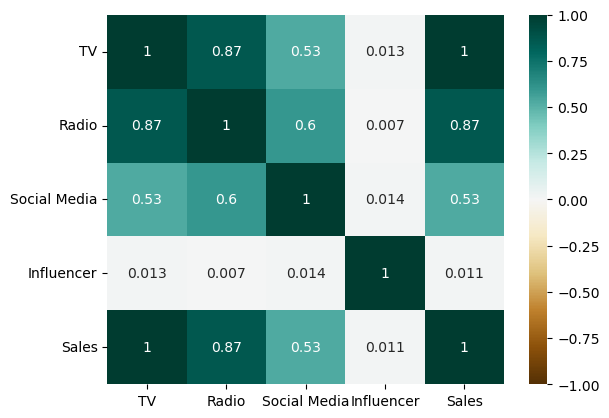

In [239]:
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap='BrBG')

### Feature importance

In [ ]:
# Random forest code ¿¿¿¿¿¿¿¿¿¿¿¿¿¿

## 3. PREDICTING MODELS

In [248]:
y = df_marketing_sales.pop("Sales")

In [249]:
X

,TV,Radio,Social Media,Influencer
0,16.0,6.566231,2.907983,3
1,13.0,9.237765,2.409567,3
2,41.0,15.886446,2.913410,3
3,83.0,30.020028,6.922304,3
4,15.0,8.437408,1.405998,2
...,...,...,...,...
4567,26.0,4.472360,0.717090,2
4568,71.0,20.610685,6.545573,1
4569,44.0,19.800072,5.096192,2
4570,71.0,17.534640,1.940873,4


In [252]:
pd.DataFrame(y, columns=['Sales'])

,Sales
0,54.732757
1,46.677897
2,150.177829
3,298.246340
4,56.594181
...,...
4567,94.685866
4568,249.101915
4569,163.631457
4570,253.610411


In [253]:
# Hold out
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=random_seed)

In [283]:
# Particiones para cross validation
kfold = KFold(n_splits=10,shuffle=True, random_state=random_seed)
for i, (train_index, test_index) in enumerate(kfold.split(X)):
    print("\nPartition number",i)
    print("----------------------")
    print("Train rows indexs:", train_index)
    print("Test rows indexs:", test_index)


Partition number 0
----------------------
Train rows indexs: [   0    4    5 ... 4540 4541 4542]
Test rows indexs: [   1    2    3   20   33   41   56   76   84   88   90  102  103  107
  112  122  146  150  155  159  163  164  177  192  232  242  247  251
  257  266  277  284  286  294  297  298  309  328  354  355  356  367
  369  370  379  381  391  406  430  431  437  441  457  477  482  492
  504  516  531  542  549  558  599  601  602  604  607  610  613  620
  634  635  641  642  645  650  682  692  697  698  705  708  732  741
  744  763  771  784  797  810  811  826  834  860  861  871  879  880
  881  901  917  925  956  961  963  969 1002 1021 1035 1036 1037 1069
 1093 1096 1109 1127 1133 1135 1147 1148 1150 1167 1170 1179 1180 1181
 1204 1210 1227 1234 1237 1242 1244 1245 1247 1255 1269 1279 1294 1301
 1303 1311 1325 1327 1328 1345 1346 1351 1362 1372 1376 1385 1409 1450
 1468 1478 1485 1518 1522 1525 1542 1543 1551 1563 1568 1603 1613 1618
 1627 1632 1660 1664 1679 1684 1

### Regresión lineal

In [255]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)

LinearRegression()

In [256]:
lreg.predict(X_test)

array([ 93.25193049, 354.9304834 , 163.60513626, ..., 206.6551706 ,
        39.30774411,  85.08929731])

In [262]:
print("Modelo lineal obtenido: \nsales = {:.2f} + {:.2f} * TV + {:.2f} * Radio + {:.2f} * SocialMedia + {:.2f} * Influencer".
      format(
    lreg.intercept_, 
    lreg.coef_.tolist()[0],
    lreg.coef_.tolist()[1],
    lreg.coef_.tolist()[2],
    lreg.coef_.tolist()[3]
) )

Modelo lineal obtenido: 
sales = 0.58 + 3.51 * TV + 0.11 * Radio + 0.06 * SocialMedia + -0.10 * Influencer


In [263]:
lreg.coef_.tolist()[0]

3.512439618630776

In [272]:
# Evaluando la bondad del modelo
print("Rendimiento (R^2) sobre entrenamiento: {:.2f}".format(lreg.score(X_train, y_train)))
print("Rendimiento (R^2) sobre test: {:.2f}".format(lreg.score(X_test, y_test)))
scores_val = cross_val_score(lreg, X, y, cv=kfold)
print("Rendimiento (R^2 medio) sobre validacion cruzada: {:.2f}".format(scores_val.mean()))

Rendimiento (R^2) sobre entrenamiento: 0.99
Rendimiento (R^2) sobre test: 0.99
Rendimiento (R^2 medio) sobre validacion cruzada: 0.99


In [273]:
# Otras metricas del modelo
mse = mean_squared_error(y_test, lreg.predict(X_test))
rmse = mean_squared_error(y_test, lreg.predict(X_test), squared=False)
r2 = r2_score(y_test, lreg.predict(X_test))
print("Mean Squared Error (MSE): {:.2f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("R-squared (R2): {:.2f}".format(r2))

Mean Squared Error (MSE): 45.64
Root Mean Squared Error (RMSE): 6.76
R-squared (R2): 0.99


In [ ]:
# Representacion ??????????????????????????????????????

## Random Forest Regression

In [301]:
rf = RandomForestRegressor(n_estimators=10, max_depth=8, random_state=random_seed)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=10, random_state=54)

In [302]:
rf.predict(X_test)

array([ 92.23917064, 354.40013634, 164.00973635, ..., 205.12675331,
        39.11063179,  84.91381325])

In [303]:
# Evaluando la bondad del modelo
print("Rendimiento (R^2) sobre entrenamiento: {:.2f}".format(rf.score(X_train, y_train)))
print("Rendimiento (R^2) sobre test: {:.2f}".format(rf.score(X_test, y_test)))
scores_val = cross_val_score(rf, X, y, cv=kfold)
print("Rendimiento (R^2) sobre validacion cruzada: {:.2f}".format(scores_val.mean()))

Rendimiento (R^2) sobre entrenamiento: 1.00
Rendimiento (R^2) sobre test: 0.99
Rendimiento (R^2) sobre validacion cruzada: 0.99


In [304]:
# Otras metricas del modelo
mse = mean_squared_error(y_test, rf.predict(X_test))
rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)
r2 = r2_score(y_test, rf.predict(X_test))
print("Mean Squared Error (MSE): {:.2f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("R-squared (R2): {:.2f}".format(r2))

Mean Squared Error (MSE): 55.21
Root Mean Squared Error (RMSE): 7.43
R-squared (R2): 0.99


In [347]:
rf.feature_importances_.reshape(1,4)

array([[9.94015125e-01, 4.00060926e-03, 1.85167009e-03, 1.32596060e-04]])

In [360]:
# Importancia de los atributos
features_importance = pd.Series(data=rf.feature_importances_, 
          index=X.columns.values.tolist())
display(pd.DataFrame(features_importance, columns=["Importance"]))

,Importance
TV,0.994015
Radio,0.004001
Social Media,0.001852
Influencer,0.000133


<Axes: >

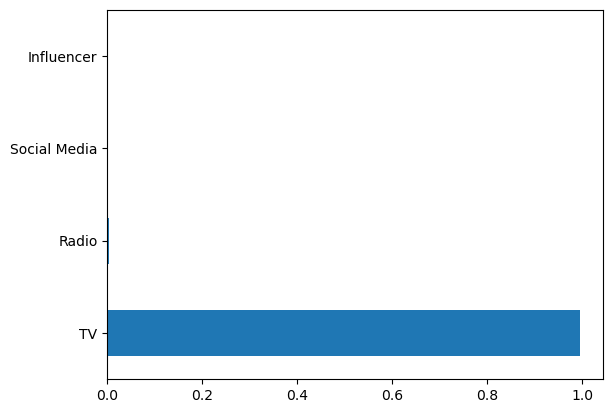

In [366]:
features_importance.plot.barh()

<Axes: >

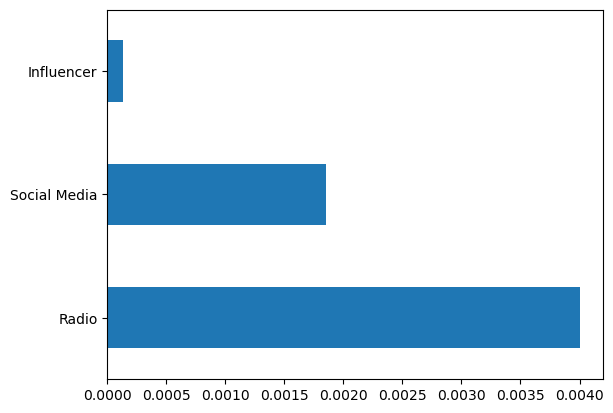

In [369]:
features_importance.drop("TV").plot.barh()

In [335]:
# Representacion ???????????????

### GridSearch

In [ ]:
# ???????????????? Lo hacemos? creo que no hace falta